# FIN 514 - Crank-Nicolson Finite Difference - European options
**Spring 2021**

This notebook provides a simple Crank-Nicolson Finite Difference Code to value European style options

## Packages and Configurations

The following common packages will be use on this notebook.

* numpy - [https://numpy.org/](https://numpy.org/)
* Pandas - [https://pandas.pydata.org/](https://pandas.pydata.org/)
* matplotlib - [https://matplotlib.org/](https://matplotlib.org/)
* Scipy Statistical functions - [https://docs.scipy.org/doc/scipy/reference/stats.html](https://docs.scipy.org/doc/scipy/reference/stats.html)


In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

In [2]:
# ENTER INPUT FOR: start_step


#jmax = 100 #Number of S steps
imax = 5000 #Number of t steps
S0 = 40.0
K = 39.0
sigma = 0.2
r = 0.005
q = 0
T = 0.5
SL = 0 #Minimum S value
SU = 2.5*S0 #Maximum S value

In [3]:
# ENTER INPUT FOR: whether option is call (1) or put (0)
cp = 1

## Black-Scholes Model 

In [4]:
def black_scholes(S0, K, T, r, q, sigma, cp):
    """
    Function to calculates the value of a European Call Option using Black Scholes 
    
    S0: Original Stock Price
    K: Excercise Price of Call Option
    T: Time Length of Option in which to Exercise (In Years)
    r: Annualized Continously Compounded Risk-free Rate
    q: Rate of continuous dividend paying asset 
    sigma: Annualized (Future) Volatility of Stock Price Returns
    
    """
    
    cdf_mean = 0.0
    cdf_sd = 1.0
    
    d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S0 / K) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if cp == 1:
        value = S0 * np.exp(-q * T) * st.norm.cdf(d1, cdf_mean, cdf_sd) 
        value = value - K * np.exp(-r * T) * st.norm.cdf(d2, cdf_mean, cdf_sd) 
    else:
        value = -S0 * np.exp(-q * T) * st.norm.cdf(-d1, cdf_mean, cdf_sd) 
        value = value + K * np.exp(-r * T) * st.norm.cdf(-d2, cdf_mean, cdf_sd) 
    
    return value

## Crank-Nicolson Finite Difference Function

In [5]:

def CNFD_model(S0, K, T, r, q, sigma, SU, jmaxmin, jmaxmax, jmaxstep, imax):
    
    #LIST TO SAVE RESULTS
    #Assumes that SL= 0, can be relaxed, see notes for updates A, B, C values in this case
    
    cnfd_result = []
    
    for jmax in range(jmaxmin, jmaxmax, jmaxstep): 
    
    # CREATE TWO DIMENSIONAL ARRAY OF SIZE [imax+1,jmax+1] TO STORE V AT ALL STEPS
    # V[imax, jmax]
    
        V = np.zeros([imax+1, jmax+1])

    # CREATE ONE DIMENSIONAL ARRAY OF SIZE [jmax+1] TO STORE A, B, C VALUES AT ALL STEPS
    # A[jmax], B[jmax], C[jmax] 
    
        A = np.zeros([jmax+1])
        B = np.zeros([jmax+1])
        C = np.zeros([jmax+1])
        D = np.zeros([jmax+1])
        alpha = np.zeros([jmax+1])
        CN_S = np.zeros([jmax+1])
    
    # Set up time and S steps
    
        dt = T / imax
        dS = SU/jmax
       
        
    # CALCULATE OPTION VALUES AND PROBABILITIES
    # Start at the last step number because we are going to be moving backwards from times step imax to times step 0
    
        i = imax 
        
        for j in range(0, jmax+1):    
    # Then, calculate the value of the option at that exact position within the binomial tree
    # Also calculate the probabilities A, B, C
           
            V[i, j] = np.maximum(j*dS - K, 0)
            A[j] = 0.25*sigma**2*j**2 - 0.25*(r-q)*j
            B[j] = -1/dt-0.5*r-0.5*sigma**2*j**2
            C[j] = 0.25*sigma**2*j**2 + 0.25*(r-q)*j

    #Now go back in time
        for i in range(imax-1, -1, -1):

            #Lower boundary condition in matrix terms
            A[0] = 0
            B[0] = 1
            C[0] = 0
            D[0] = 0
    
            #regular D values
            for j in range(1, jmax, 1):
                
                D1 = -V[i+1,j-1]*(0.25*sigma**2*j**2-0.25*(r-q)*j)
                D2 = -V[i+1,j]*(1/dt-0.5*r-0.5*sigma**2*j**2)
                D3 = -V[i+1,j+1]*(0.25*sigma**2*j**2+0.25*(r-q)*j)
                D[j] = D1+D2+D3
            
            #Upper boundary condition in matrix terms
            A[jmax] = 0
            B[jmax] = 1
            C[jmax] = 0
            D[jmax] = SU*np.exp(-q*(T-i*dt))-K*np.exp(-r*(T-i*dt))
            
            
            alpha[0] = B[0]
            CN_S[0] = D[0]
            for j in range(1, jmax+1, 1):
                alpha[j] = B[j]-(A[j]*C[j-1])/alpha[j-1]
                CN_S[j] = D[j]-(A[j]*CN_S[j-1])/alpha[j-1]  
            V[i,jmax] = CN_S[jmax]/alpha[jmax]
            for j in range(jmax-1,-1,-1):
                V[i,j] = (CN_S[j]-C[j]*V[i,j+1])/alpha[j]
                
    # RELAY OUTPUTS TO DICTIONARY
        jcritreal = S0/dS
        jcrit = int(jcritreal)
        jcritK = int(K/dS)+1
        Vcrit = V[0,jcrit]+ (S0 - jcrit * dS) / (dS) * (V[0,jcrit+1] - V[0,jcrit])
        Klambda = (jcritK*dS - K)/dS
        output = {'S_steps': jmax, 't_steps': imax, 'CN': Vcrit, 'Lambda': Klambda}
        cnfd_result.append(output)

    return cnfd_result


In [6]:
cnfd = CNFD_model(S0, K, T, r, q, sigma, SU, 40, 500, 20, 5000)

In [7]:
bsc_value = black_scholes(S0, K, T, r, q, sigma,cp)
bsc_value

2.815448444060152

In [8]:
# CREATE A DATAFRAME FROM THE BINOMIAL MODEL OUTPUT
df = pd.DataFrame.from_dict(cnfd)

In [9]:
# CALCULATE THE ERROR FROM BINOMIAL MODEL COMPARED WITH BLACK-SHCOLES
df['error_cn'] = df["CN"] - bsc_value 

In [10]:
# INSPECT THE FIRST ROWS OF THE DATAFRAME
df.head()

,S_steps,t_steps,CN,Lambda,error_cn
0,40,5000,2.815411,0.4,-0.000037
1,60,5000,2.815399,0.6,-0.000050
2,80,5000,2.810890,0.8,-0.004559
3,100,5000,2.806789,1.0,-0.008659
4,120,5000,2.813438,0.2,-0.002010


In [11]:
# INSPECT THE LAST ROWS OF THE DATAFRAME
df.tail()

,S_steps,t_steps,CN,Lambda,error_cn
18,400,5000,2.814910,1.0,-0.000538
19,420,5000,2.815285,0.2,-0.000164
20,440,5000,2.815447,0.4,-0.000001
21,460,5000,2.815447,0.6,-0.000001
22,480,5000,2.815323,0.8,-0.000125


In [12]:
# EXPORT THE DATA TO A CSV FILE
df.to_csv("Data/cn.csv", index=False)

CN finite difference error profile with varying lambda

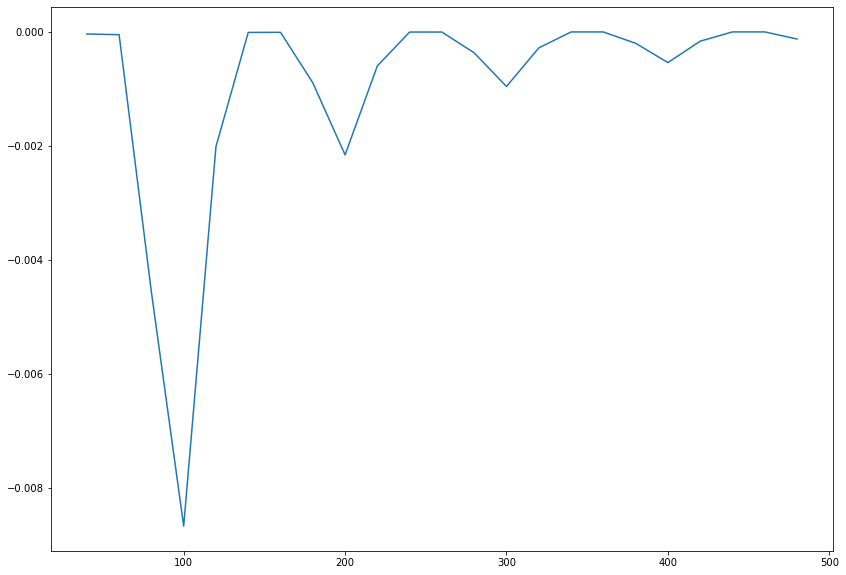

In [13]:
plt.figure(figsize=(14,10))
plt.plot(df['S_steps'], df['error_cn'], '-', markersize=3)
plt.savefig('Images/cneur1.png')
plt.show()

In [14]:
# ENTER INPUT FOR: start_step


#jmax = 100 #Number of S steps
imax = 5000 #Number of t steps
S0 = 40.0
K = 40.0
sigma = 0.2
r = 0.005
q = 0
T = 0.5
SL = 0 #Minimum S value
SU = 2.5*S0 #Maximum S value

In [15]:
cnfd = CNFD_model(S0, K, T, r, q, sigma, SU, 40, 500, 20, 5000)

In [16]:
bsc_value = black_scholes(S0, K, T, r, q, sigma,cp)
bsc_value

2.302352874900283

In [17]:
# CREATE A DATAFRAME FROM THE BINOMIAL MODEL OUTPUT
df = pd.DataFrame.from_dict(cnfd)

In [18]:
# CALCULATE THE ERROR FROM BINOMIAL MODEL COMPARED WITH BLACK-SHCOLES
df['error_cn'] = df["CN"] - bsc_value 

### Crank-Nicolson finite difference error profile with fixed lambda 

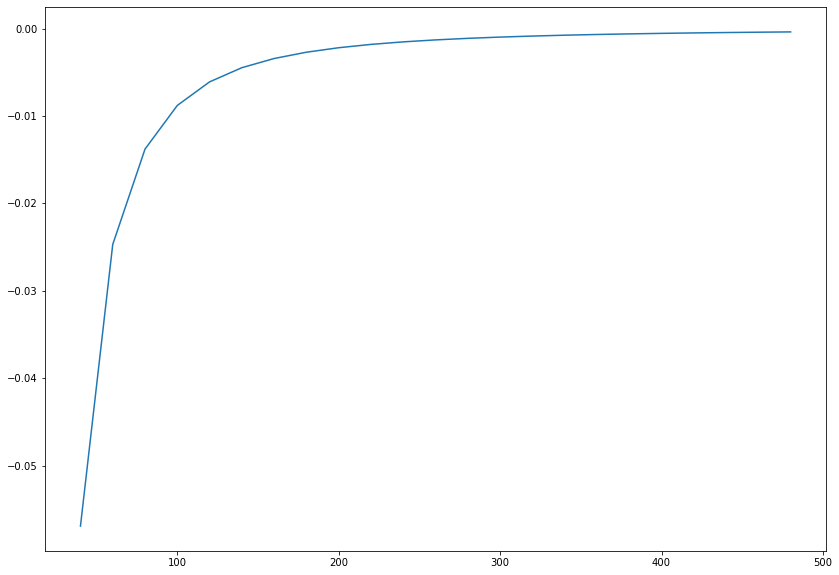

In [19]:
plt.figure(figsize=(14,10))
plt.plot(df['S_steps'], df['error_cn'], '-', markersize=3)
plt.savefig('Images/cneur2.png')
plt.show()

In [20]:
# ENTER INPUT FOR: start_step


#jmax = 100 #Number of S steps
imax = 5000 #Number of t steps
S0 = 40.0
K = 39.0
sigma = 0.2
r = 0.005
q = 0
T = 0.5
SL = 0 #Minimum S value
SU = 2.5*S0 #Maximum S value

In [21]:
cnfd = CNFD_model(S0, K, T, r, q, sigma, SU, 50, 500, 100, 5000)

In [22]:
bsc_value = black_scholes(S0, K, T, r, q, sigma,cp)
bsc_value

2.815448444060152

In [23]:
# CREATE A DATAFRAME FROM THE BINOMIAL MODEL OUTPUT
df = pd.DataFrame.from_dict(cnfd)

In [24]:
# CALCULATE THE ERROR FROM BINOMIAL MODEL COMPARED WITH BLACK-SHCOLES
df['error_cn'] = df["CN"] - bsc_value 

### Crank-Nicolson finite difference error profile with fixed lambda but K = 39

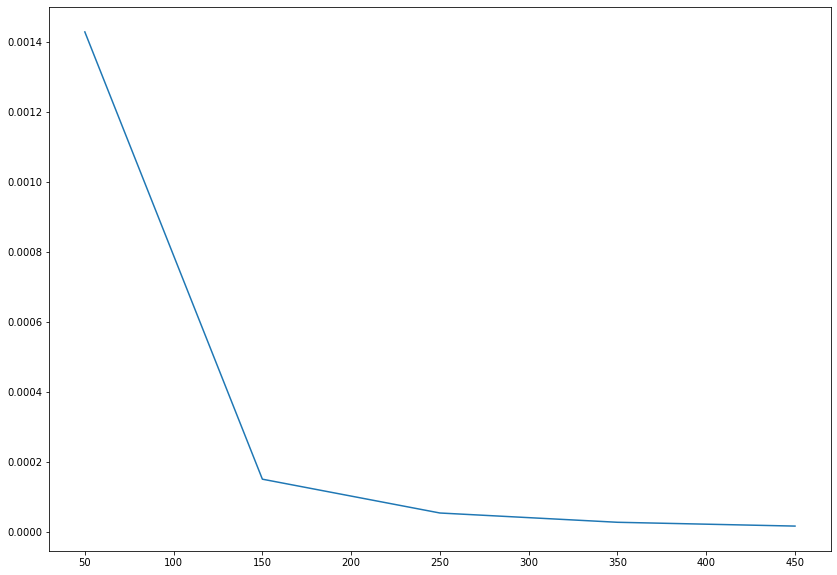

In [25]:
plt.figure(figsize=(14,10))
plt.plot(df['S_steps'], df['error_cn'], '-', markersize=3)
plt.savefig('Images/cneur3.png')
plt.show()